In [27]:
# Analiza danych taksówkowych i budowa modeli regresji

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Ustawienie stylu wykresów
plt.style.use('default')
sns.set_palette("husl")

print("=== ANALIZA DANYCH TAKSÓWKOWYCH ===")
print("Autorzy: [Wpisz swoje dane]")
print("=" * 50)

# 1. WCZYTANIE I PODSTAWOWA ANALIZA DANYCH
print("\n1. WCZYTANIE DANYCH")
print("-" * 30)

# Wczytanie danych z poprawnym separatorem
df = pd.read_csv('taxi_trip_pricing.csv', sep=';')

print(f"Rozmiar danych: {df.shape}")
print(f"Liczba wierszy: {df.shape[0]}")
print(f"Liczba kolumn: {df.shape[1]}")

print("\nPierwsze 5 wierszy:")
print(df.head())

print("\nInformacje o danych:")
print(df.info())

print("\nStatystyki opisowe:")
print(df.describe())

=== ANALIZA DANYCH TAKSÓWKOWYCH ===
Autorzy: [Wpisz swoje dane]

1. WCZYTANIE DANYCH
------------------------------
Rozmiar danych: (1000, 11)
Liczba wierszy: 1000
Liczba kolumn: 11

Pierwsze 5 wierszy:
  Trip_Distance_km Time_of_Day Day_of_Week Passenger_Count Traffic_Conditions  \
0            19,35     Morning     Weekday               3                Low   
1            47,59   Afternoon     Weekday               1               High   
2            36,87     Evening     Weekend               1               High   
3            30,33     Evening     Weekday               4                Low   
4                      Evening     Weekday               3               High   

  Weather Base_Fare Per_Km_Rate Per_Minute_Rate Trip_Duration_Minutes  \
0   Clear      3,56        0,80            0,32                 53,82   
1   Clear                  0,62            0,43                 40,57   
2   Clear      2,70        1,21            0,15                 37,27   
3              3,4

In [19]:
# 2. ANALIZA JAKOŚCI DANYCH I CZYSZCZENIE
print("\n\n2. ANALIZA JAKOŚCI DANYCH")
print("-" * 30)

# Sprawdzenie brakujących wartości
print("Brakujące wartości w każdej kolumnie:")
missing_values = df.isnull().sum()
print(missing_values)

# Sprawdzenie pustych stringów i białych znaków
print("\nSprawdzenie pustych stringów i białych znaków:")
for col in df.columns:
    if df[col].dtype == 'object':
        empty_strings = (df[col].str.strip() == '').sum()
        print(f"{col}: {empty_strings} pustych stringów")

# Zastąpienie pustych stringów wartościami NaN
df = df.replace('', np.nan)
df = df.replace(' ', np.nan)

# Konwersja kolumn numerycznych (zastąpienie przecinków kropkami)
numeric_columns = ['Trip_Distance_km', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 
                   'Trip_Duration_Minutes', 'Trip_Price', 'Passenger_Count']

for col in numeric_columns:
    if col in df.columns:
        # Zastąpienie przecinków kropkami
        df[col] = df[col].astype(str).str.replace(',', '.')
        # Konwersja do float
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nPo konwersji - brakujące wartości:")
print(df.isnull().sum())

print("\nStatystyki po czyszczeniu:")
print(df.describe())



2. ANALIZA JAKOŚCI DANYCH
------------------------------
Brakujące wartości w każdej kolumnie:
Trip_Distance_km         0
Time_of_Day              0
Day_of_Week              0
Passenger_Count          0
Traffic_Conditions       0
Weather                  0
Base_Fare                0
Per_Km_Rate              0
Per_Minute_Rate          0
Trip_Duration_Minutes    0
Trip_Price               0
dtype: int64

Sprawdzenie pustych stringów i białych znaków:
Trip_Distance_km: 50 pustych stringów
Time_of_Day: 50 pustych stringów
Day_of_Week: 50 pustych stringów
Passenger_Count: 50 pustych stringów
Traffic_Conditions: 50 pustych stringów
Weather: 50 pustych stringów
Base_Fare: 50 pustych stringów
Per_Km_Rate: 50 pustych stringów
Per_Minute_Rate: 50 pustych stringów
Trip_Duration_Minutes: 50 pustych stringów
Trip_Price: 49 pustych stringów

Po konwersji - brakujące wartości:
Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Con

In [20]:
# 3. UZUPEŁNIENIE BRAKUJĄCYCH WARTOŚCI
print("\n\n3. UZUPEŁNIENIE BRAKUJĄCYCH WARTOŚCI")
print("-" * 30)

# Strategia uzupełniania dla różnych typów zmiennych
# Zmienne numeryczne - mediana
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Uzupełniono {col} medianą: {median_val:.2f}")

# Zmienne kategoryczne - moda
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
        df[col].fillna(mode_val, inplace=True)
        print(f"Uzupełniono {col} modą: {mode_val}")

print(f"\nPo uzupełnieniu - pozostałe braki: {df.isnull().sum().sum()}")



3. UZUPEŁNIENIE BRAKUJĄCYCH WARTOŚCI
------------------------------
Uzupełniono Trip_Distance_km medianą: 25.83
Uzupełniono Passenger_Count medianą: 2.00
Uzupełniono Base_Fare medianą: 3.52
Uzupełniono Per_Km_Rate medianą: 1.22
Uzupełniono Per_Minute_Rate medianą: 0.29
Uzupełniono Trip_Duration_Minutes medianą: 61.86
Uzupełniono Trip_Price medianą: 50.07
Uzupełniono Time_of_Day modą: Afternoon
Uzupełniono Day_of_Week modą: Weekday
Uzupełniono Traffic_Conditions modą: Low
Uzupełniono Weather modą: Clear

Po uzupełnieniu - pozostałe braki: 0




4. EKSPLORACYJNA ANALIZA DANYCH
------------------------------


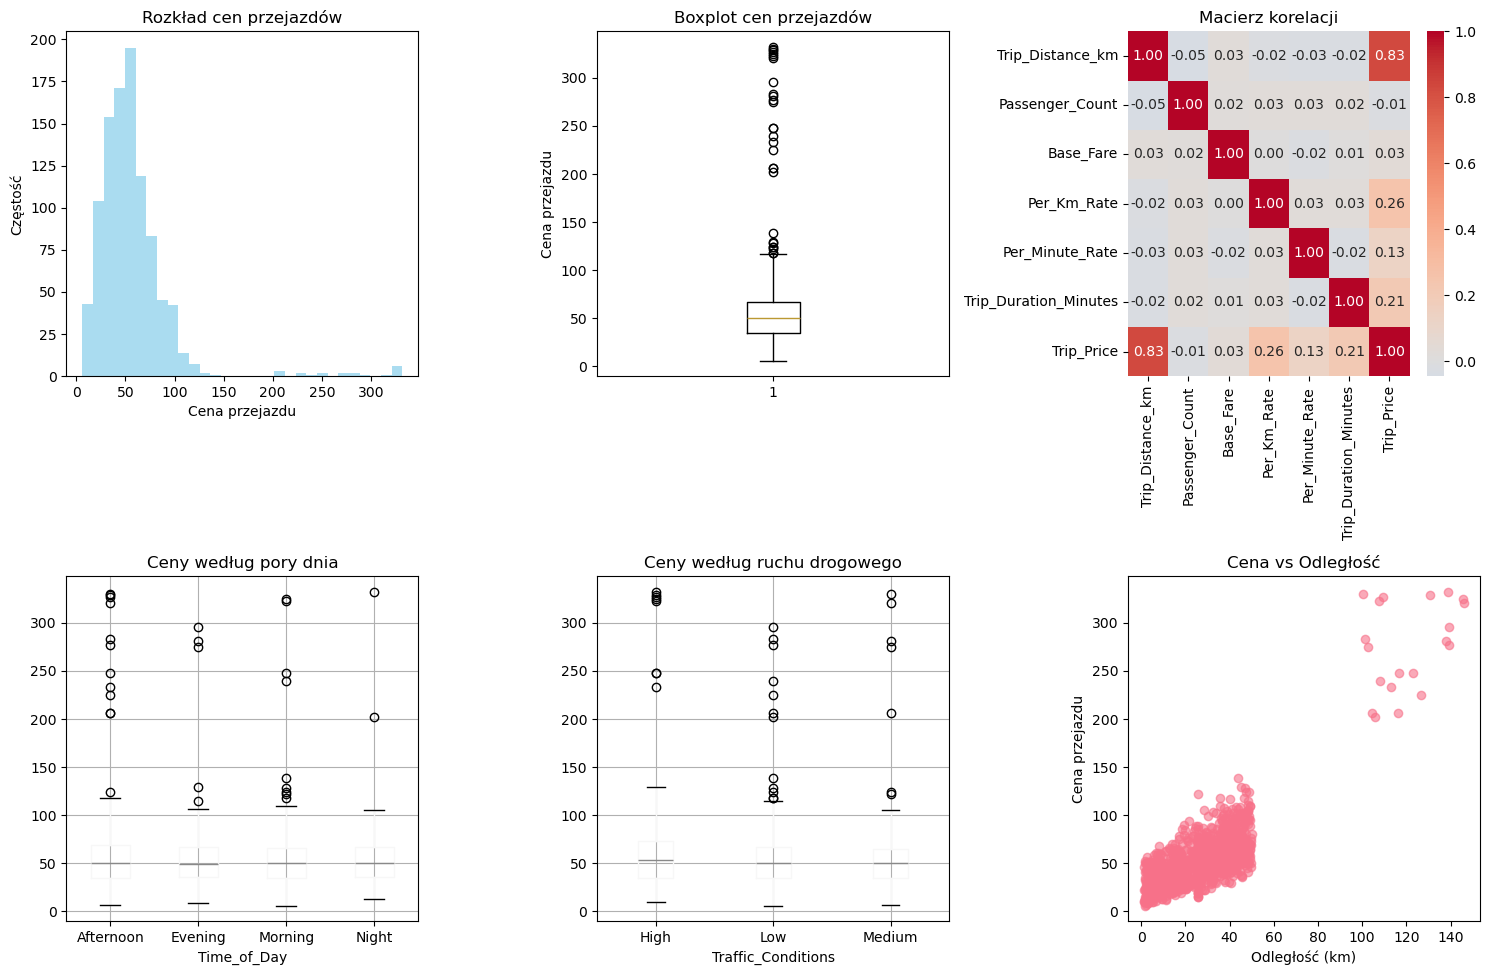


Korelacje z ceną przejazdu:
Trip_Price               1.000000
Trip_Distance_km         0.830482
Per_Km_Rate              0.256118
Trip_Duration_Minutes    0.214669
Per_Minute_Rate          0.131533
Base_Fare                0.033101
Passenger_Count         -0.012468
Name: Trip_Price, dtype: float64

Analiza zmiennych kategorycznych:

Time_of_Day:
              mean  median    std
Time_of_Day                      
Afternoon    57.46   50.07  42.68
Evening      56.22   49.79  36.96
Morning      55.58   50.07  36.59
Night        56.04   50.07  38.86

Day_of_Week:
              mean  median    std
Day_of_Week                      
Weekday      57.27   50.07  41.29
Weekend      54.80   49.51  34.83

Traffic_Conditions:
                     mean  median    std
Traffic_Conditions                      
High                64.24   53.08  56.20
Low                 55.22   50.07  34.45
Medium              54.35   50.07  34.63

Weather:
          mean  median    std
Weather                      
C

In [21]:
# 4. EKSPLORACYJNA ANALIZA DANYCH
print("\n\n4. EKSPLORACYJNA ANALIZA DANYCH")
print("-" * 30)

# Analiza zmiennej docelowej
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['Trip_Price'], bins=30, alpha=0.7, color='skyblue')
plt.title('Rozkład cen przejazdów')
plt.xlabel('Cena przejazdu')
plt.ylabel('Częstość')

plt.subplot(2, 3, 2)
plt.boxplot(df['Trip_Price'])
plt.title('Boxplot cen przejazdów')
plt.ylabel('Cena przejazdu')

# Korelacje zmiennych numerycznych
plt.subplot(2, 3, 3)
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Macierz korelacji')

# Analiza według pory dnia
plt.subplot(2, 3, 4)
df.boxplot(column='Trip_Price', by='Time_of_Day', ax=plt.gca())
plt.title('Ceny według pory dnia')
plt.suptitle('')

# Analiza według warunków drogowych
plt.subplot(2, 3, 5)
df.boxplot(column='Trip_Price', by='Traffic_Conditions', ax=plt.gca())
plt.title('Ceny według ruchu drogowego')
plt.suptitle('')

# Zależność cena vs odległość
plt.subplot(2, 3, 6)
plt.scatter(df['Trip_Distance_km'], df['Trip_Price'], alpha=0.6)
plt.xlabel('Odległość (km)')
plt.ylabel('Cena przejazdu')
plt.title('Cena vs Odległość')

plt.tight_layout()
plt.savefig('exploratory_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Szczegółowa analiza korelacji z ceną
print("\nKorelacje z ceną przejazdu:")
price_correlations = correlation_matrix['Trip_Price'].sort_values(key=abs, ascending=False)
print(price_correlations)

# Analiza zmiennych kategorycznych
print("\nAnaliza zmiennych kategorycznych:")
categorical_vars = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']
for var in categorical_vars:
    if var in df.columns:
        print(f"\n{var}:")
        print(df.groupby(var)['Trip_Price'].agg(['mean', 'median', 'std']).round(2))


In [22]:
# 5. PRZYGOTOWANIE DANYCH DO MODELOWANIA
print("\n\n5. PRZYGOTOWANIE DANYCH DO MODELOWANIA")
print("-" * 30)


indices = [313142, 308046]  
seed = int(np.floor(np.mean(indices)))
print(f"Numery indeksów: {indices}")
print(f"Średnia: {np.mean(indices)}")
print(f"Ziarno (zaokrąglone w dół): {seed}")

np.random.seed(seed)

# Wybór predyktorów na podstawie analizy
print("\nWybór predyktorów:")

# Usunięcie zmiennych o bardzo wysokiej korelacji (mogą powodować problem multikolinearności)
selected_features = ['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count', 
                    'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate', 
                    'Per_Minute_Rate', 'Trip_Duration_Minutes']

print("Wybrane predyktory:")
for feature in selected_features:
    print(f"- {feature}")

# Przygotowanie danych
X = df[selected_features].copy()
y = df['Trip_Price'].copy()

# Kodowanie zmiennych kategorycznych
le_dict = {}
categorical_features = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

for feature in categorical_features:
    if feature in X.columns:
        le = LabelEncoder()
        X[feature] = le.fit_transform(X[feature].astype(str))
        le_dict[feature] = le
        print(f"Zakodowano {feature}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Podział na zbiory uczący i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print(f"\nRozmiary zbiorów:")
print(f"Zbiór uczący: {X_train.shape[0]} próbek")
print(f"Zbiór testowy: {X_test.shape[0]} próbek")



5. PRZYGOTOWANIE DANYCH DO MODELOWANIA
------------------------------
Numery indeksów: [313142, 308046]
Średnia: 310594.0
Ziarno (zaokrąglone w dół): 310594

Wybór predyktorów:
Wybrane predyktory:
- Trip_Distance_km
- Time_of_Day
- Day_of_Week
- Passenger_Count
- Traffic_Conditions
- Weather
- Base_Fare
- Per_Km_Rate
- Per_Minute_Rate
- Trip_Duration_Minutes
Zakodowano Time_of_Day: {'Afternoon': 0, 'Evening': 1, 'Morning': 2, 'Night': 3}
Zakodowano Day_of_Week: {'Weekday': 0, 'Weekend': 1}
Zakodowano Traffic_Conditions: {'High': 0, 'Low': 1, 'Medium': 2}
Zakodowano Weather: {'Clear': 0, 'Rain': 1, 'Snow': 2}

Rozmiary zbiorów:
Zbiór uczący: 800 próbek
Zbiór testowy: 200 próbek


In [23]:
# 6. BUDOWA MODELI
print("\n\n6. BUDOWA MODELI REGRESJI")
print("-" * 30)

# Funkcje do obliczania metryk
def calculate_metrics(y_true, y_pred, dataset_name, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"{model_name} - {dataset_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.4f}%")
    
    return rmse, mae, mape

# MODEL 1: REGRESJA LINIOWA
print("\nMODEL 1: REGRESJA LINIOWA")
print("-" * 25)

# Standaryzacja danych dla regresji liniowej
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Trenowanie modelu
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predykcje
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Metryki
lr_train_metrics = calculate_metrics(y_train, y_train_pred_lr, "Zbiór uczący", "Regresja Liniowa")
lr_test_metrics = calculate_metrics(y_test, y_test_pred_lr, "Zbiór testowy", "Regresja Liniowa")

# Ważność cech
feature_importance_lr = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nNajważniejsze cechy (Regresja Liniowa):")
print(feature_importance_lr.head(5))

# MODEL 2: RANDOM FOREST
print("\n\nMODEL 2: RANDOM FOREST")
print("-" * 25)

# Wyszukiwanie najlepszych hiperparametrów
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Wyszukiwanie najlepszych hiperparametrów...")
rf = RandomForestRegressor(random_state=seed)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Najlepsze parametry: {grid_search.best_params_}")

# Trenowanie najlepszego modelu
best_rf = grid_search.best_estimator_
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

# Metryki
rf_train_metrics = calculate_metrics(y_train, y_train_pred_rf, "Zbiór uczący", "Random Forest")
rf_test_metrics = calculate_metrics(y_test, y_test_pred_rf, "Zbiór testowy", "Random Forest")

# Ważność cech
feature_importance_rf = pd.DataFrame({
    'feature': selected_features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nNajważniejsze cechy (Random Forest):")
print(feature_importance_rf.head(5))



6. BUDOWA MODELI REGRESJI
------------------------------

MODEL 1: REGRESJA LINIOWA
-------------------------
Regresja Liniowa - Zbiór uczący:
  RMSE: 15.2554
  MAE:  9.9186
  MAPE: 24.2301%
Regresja Liniowa - Zbiór testowy:
  RMSE: 18.6496
  MAE:  10.9366
  MAPE: 25.2594%

Najważniejsze cechy (Regresja Liniowa):
                 feature  coefficient  abs_coefficient
0       Trip_Distance_km    33.662460        33.662460
7            Per_Km_Rate     9.983096         9.983096
9  Trip_Duration_Minutes     8.991998         8.991998
8        Per_Minute_Rate     5.900497         5.900497
4     Traffic_Conditions    -0.523986         0.523986


MODEL 2: RANDOM FOREST
-------------------------
Wyszukiwanie najlepszych hiperparametrów...
Najlepsze parametry: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest - Zbiór uczący:
  RMSE: 4.2327
  MAE:  2.6420
  MAPE: 5.3727%
Random Forest - Zbiór testowy:
  RMSE: 10.9483
  MAE:  6.8562
  MAPE: 15.0



7. PORÓWNANIE MODELI
------------------------------
Porównanie modeli:
              Model  RMSE_train  MAE_train  MAPE_train  RMSE_test  MAE_test  \
0  Regresja Liniowa     15.2554     9.9186     24.2301    18.6496   10.9366   
1     Random Forest      4.2327     2.6420      5.3727    10.9483    6.8562   

   MAPE_test  
0    25.2594  
1    15.0539  


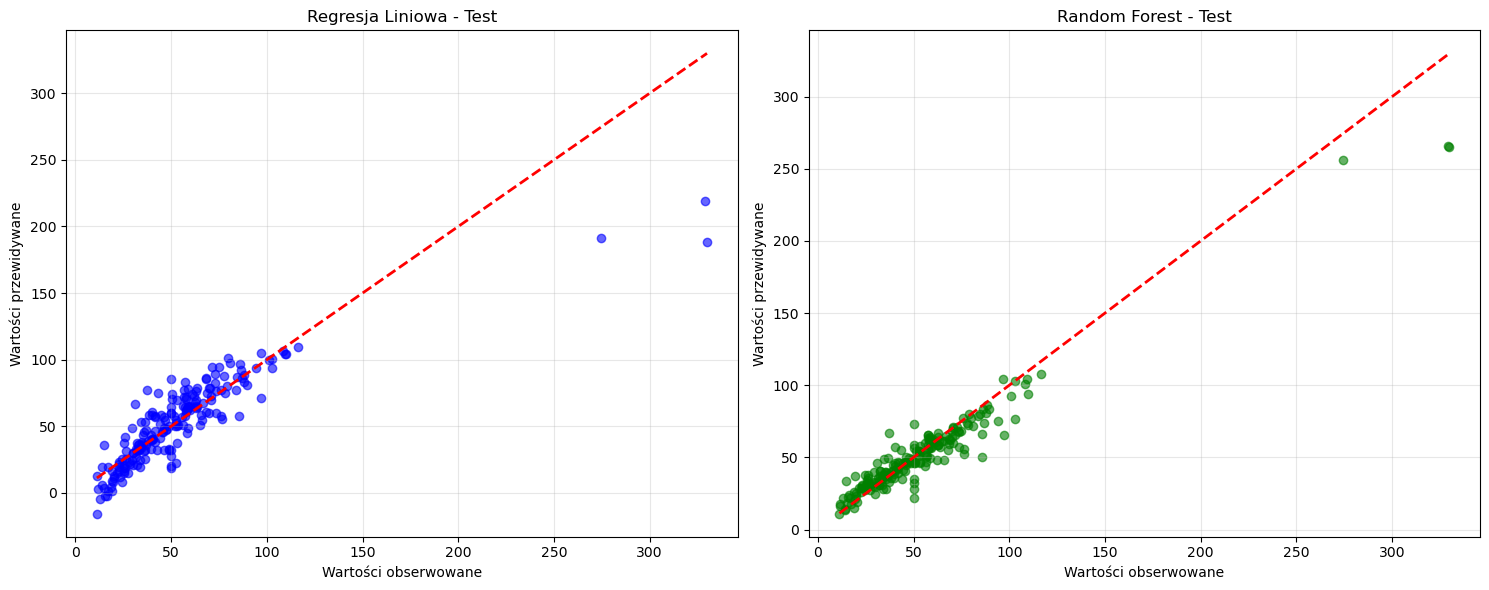

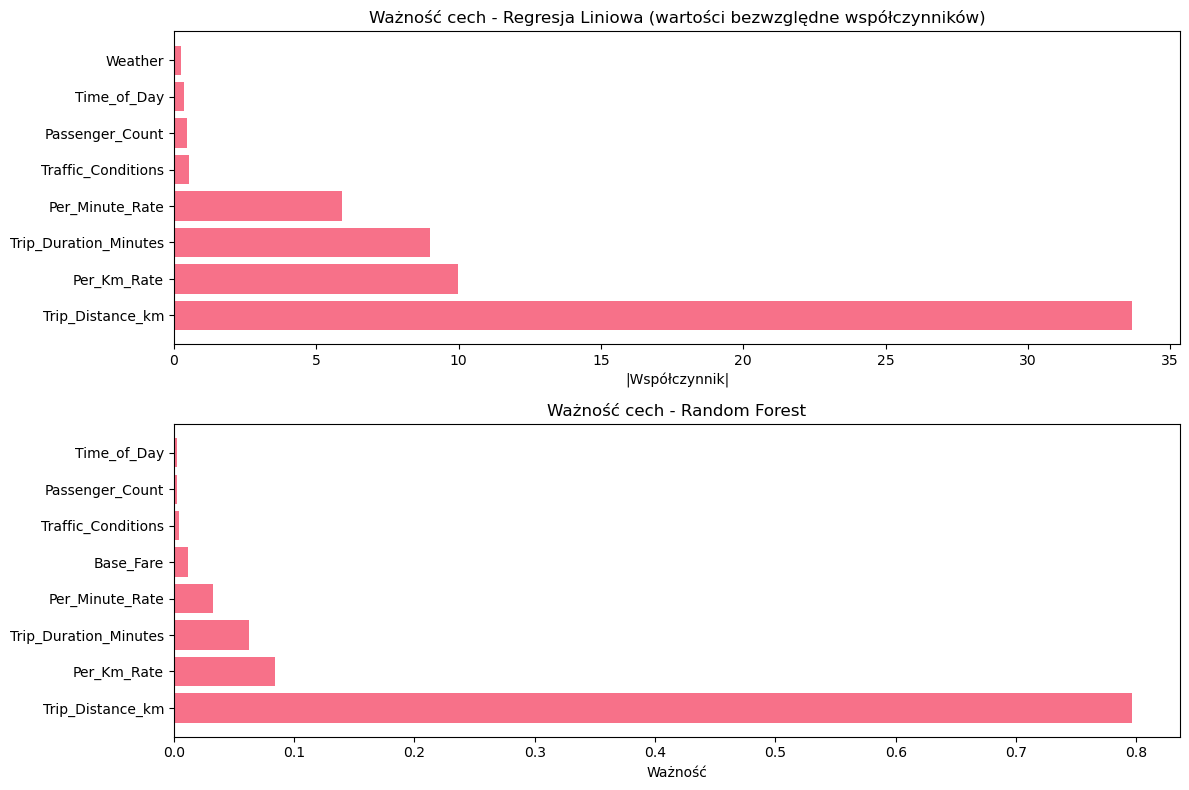

In [24]:
# 7. PORÓWNANIE MODELI I WIZUALIZACJA
print("\n\n7. PORÓWNANIE MODELI")
print("-" * 30)

# Tabela porównawcza
comparison = pd.DataFrame({
    'Model': ['Regresja Liniowa', 'Random Forest'],
    'RMSE_train': [lr_train_metrics[0], rf_train_metrics[0]],
    'MAE_train': [lr_train_metrics[1], rf_train_metrics[1]],
    'MAPE_train': [lr_train_metrics[2], rf_train_metrics[2]],
    'RMSE_test': [lr_test_metrics[0], rf_test_metrics[0]],
    'MAE_test': [lr_test_metrics[1], rf_test_metrics[1]],
    'MAPE_test': [lr_test_metrics[2], rf_test_metrics[2]]
})

print("Porównanie modeli:")
print(comparison.round(4))

# Wykres przewidywane vs obserwowane
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_lr, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Wartości obserwowane')
plt.ylabel('Wartości przewidywane')
plt.title('Regresja Liniowa - Test')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Wartości obserwowane')
plt.ylabel('Wartości przewidywane')
plt.title('Random Forest - Test')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Wykres ważności cech
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.barh(feature_importance_lr['feature'][:8], feature_importance_lr['abs_coefficient'][:8])
plt.title('Ważność cech - Regresja Liniowa (wartości bezwzględne współczynników)')
plt.xlabel('|Współczynnik|')

plt.subplot(2, 1, 2)
plt.barh(feature_importance_rf['feature'][:8], feature_importance_rf['importance'][:8])
plt.title('Ważność cech - Random Forest')
plt.xlabel('Ważność')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()



8. ANALIZA RESZT
------------------------------


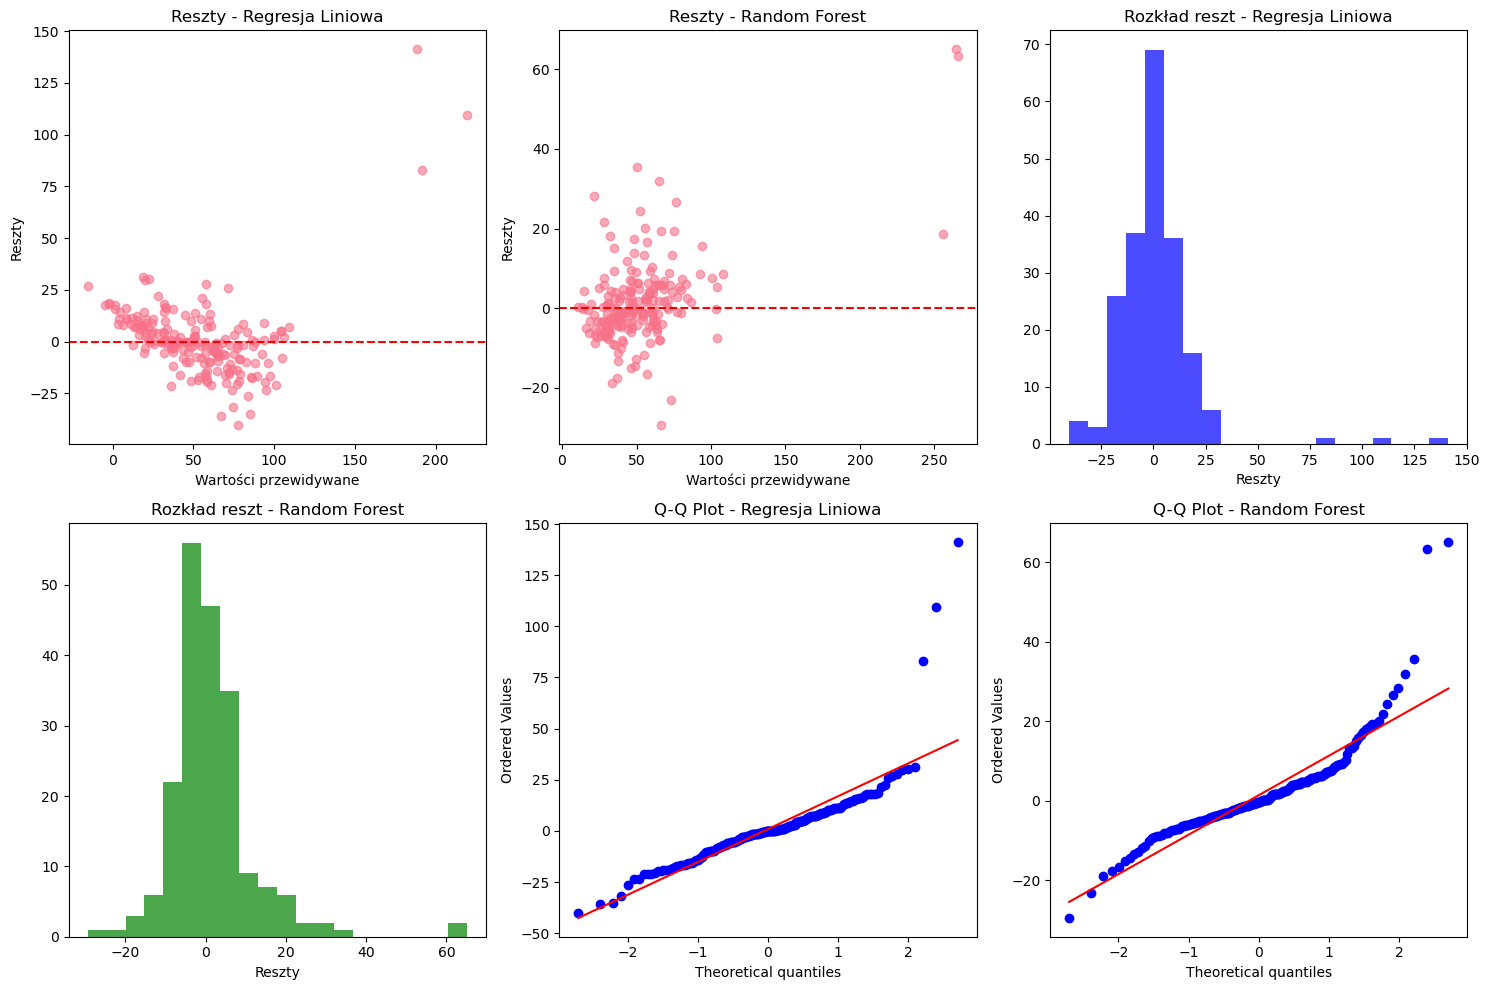


Statystyki reszt - Regresja Liniowa:
Średnia reszt: 0.8835
Mediana reszt: -0.2646
Odchylenie standardowe reszt: 18.6287
Min reszt: -40.3249
Max reszt: 141.2907

Statystyki reszt - Random Forest:
Średnia reszt: 1.4137
Mediana reszt: -0.2418
Odchylenie standardowe reszt: 10.8567
Min reszt: -29.4350
Max reszt: 65.0894


<Figure size 640x480 with 0 Axes>

In [30]:
# 8. ANALIZA RESZT
print("\n\n8. ANALIZA RESZT")
print("-" * 30)

# Reszty dla obu modeli
residuals_lr = y_test - y_test_pred_lr
residuals_rf = y_test - y_test_pred_rf

plt.figure(figsize=(15, 10))

# Wykres reszt vs przewidywane
plt.subplot(2, 3, 1)
plt.scatter(y_test_pred_lr, residuals_lr, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Wartości przewidywane')
plt.ylabel('Reszty')
plt.title('Reszty - Regresja Liniowa')

plt.subplot(2, 3, 2)
plt.scatter(y_test_pred_rf, residuals_rf, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Wartości przewidywane')
plt.ylabel('Reszty')
plt.title('Reszty - Random Forest')

# Histogram reszt
plt.subplot(2, 3, 3)
plt.hist(residuals_lr, bins=20, alpha=0.7, color='blue')
plt.title('Rozkład reszt - Regresja Liniowa')
plt.xlabel('Reszty')

plt.subplot(2, 3, 4)
plt.hist(residuals_rf, bins=20, alpha=0.7, color='green')
plt.title('Rozkład reszt - Random Forest')
plt.xlabel('Reszty')

# Q-Q plot dla normalności reszt
from scipy import stats

plt.subplot(2, 3, 5)
stats.probplot(residuals_lr, dist="norm", plot=plt)
plt.title('Q-Q Plot - Regresja Liniowa')

plt.subplot(2, 3, 6)
stats.probplot(residuals_rf, dist="norm", plot=plt)
plt.title('Q-Q Plot - Random Forest')

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nStatystyki reszt - Regresja Liniowa:")
print(f"Średnia reszt: {np.mean(residuals_lr):.4f}")
print(f"Mediana reszt: {np.median(residuals_lr):.4f}")
print(f"Odchylenie standardowe reszt: {np.std(residuals_lr):.4f}")
print(f"Min reszt: {np.min(residuals_lr):.4f}")
print(f"Max reszt: {np.max(residuals_lr):.4f}")

print("\nStatystyki reszt - Random Forest:")
print(f"Średnia reszt: {np.mean(residuals_rf):.4f}")
print(f"Mediana reszt: {np.median(residuals_rf):.4f}")
print(f"Odchylenie standardowe reszt: {np.std(residuals_rf):.4f}")
print(f"Min reszt: {np.min(residuals_rf):.4f}")
print(f"Max reszt: {np.max(residuals_rf):.4f}")

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# 9. WNIOSKI I REKOMENDACJE
print("\n\n9. WNIOSKI I REKOMENDACJE")
print("-" * 30)

print("GŁÓWNE WNIOSKI:")
print("1. Analiza danych:")
print("   - Dane wymagały znacznego czyszczenia (braki, przecinki zamiast kropek)")
print("   - Najsilniejsze korelacje z ceną: odległość, czas trwania, stawki")

print("\n2. Porównanie modeli:")
if rf_test_metrics[0] < lr_test_metrics[0]:  # Porównanie RMSE
    print("   - Random Forest osiągnął lepsze wyniki niż Regresja Liniowa")
    better_model = "Random Forest"
else:
    print("   - Regresja Liniowa osiągnęła lepsze wyniki niż Random Forest")
    better_model = "Regresja Liniowa"

print(f"   - Rekomendowany model: {better_model}")

print("\n3. Najważniejsze predyktory:")
print("   Random Forest:", ", ".join(feature_importance_rf.head(3)['feature'].tolist()))
print("   Regresja Liniowa:", ", ".join(feature_importance_lr.head(3)['feature'].tolist()))

# Sprawdzenie przeuczenia
train_test_diff_lr = abs(lr_train_metrics[0] - lr_test_metrics[0])
train_test_diff_rf = abs(rf_train_metrics[0] - rf_test_metrics[0])

print(f"\n4. Analiza przeuczenia:")
print(f"   - Różnica RMSE (train-test) Regresja Liniowa: {train_test_diff_lr:.4f}")
print(f"   - Różnica RMSE (train-test) Random Forest: {train_test_diff_rf:.4f}")

if train_test_diff_rf > train_test_diff_lr * 2:
    print("   - Random Forest może być przeuczony")
elif train_test_diff_lr > train_test_diff_rf * 2:
    print("   - Regresja Liniowa może być przeuczana")
else:
    print("   - Oba modele wydają się być odpowiednio dopasowane")

print("\n" + "="*50)
print("ANALIZA ZAKOŃCZONA")
print("Zapisano wykresy: exploratory_analysis.png, model_predictions.png,")
print("feature_importance.png, residual_analysis.png")
print("="*50)



9. WNIOSKI I REKOMENDACJE
------------------------------
GŁÓWNE WNIOSKI:
1. Analiza danych:
   - Dane wymagały znacznego czyszczenia (braki, przecinki zamiast kropek)
   - Najsilniejsze korelacje z ceną: odległość, czas trwania, stawki

2. Porównanie modeli:
   - Random Forest osiągnął lepsze wyniki niż Regresja Liniowa
   - Rekomendowany model: Random Forest

3. Najważniejsze predyktory:
   Random Forest: Trip_Distance_km, Per_Km_Rate, Trip_Duration_Minutes
   Regresja Liniowa: Trip_Distance_km, Per_Km_Rate, Trip_Duration_Minutes

4. Analiza przeuczenia:
   - Różnica RMSE (train-test) Regresja Liniowa: 3.3942
   - Różnica RMSE (train-test) Random Forest: 6.7156
   - Oba modele wydają się być odpowiednio dopasowane

ANALIZA ZAKOŃCZONA
Zapisano wykresy: exploratory_analysis.png, model_predictions.png,
feature_importance.png, residual_analysis.png
